In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


Load & clean

In [4]:

df = pd.read_csv("keystrokes_labeled.csv")


In [5]:
df.columns

Index(['timestamp', 'target_text', 'typed_text', 'typing_speed', 'errors',
       'backspaces', 'mean_inter_key_interval', 'z_errors', 'z_backspaces',
       'z_iki', 'z_speed', 'risk_index', 'label'],
      dtype='object')

 EDA

In [6]:
print(df.head(4))

             timestamp                                   target_text  \
0  2025-08-16 19:32:56  Typing fast can be fun but tricky sometimes.   
1  2025-08-16 19:32:59  Typing fast can be fun but tricky sometimes.   
2  2025-08-16 19:33:19  Typing fast can be fun but tricky sometimes.   
3  2025-08-16 19:34:04  Typing fast can be fun but tricky sometimes.   

                                      typed_text  typing_speed  errors  \
0    Typing fast can be fun buf tricky sometimes      1.685085       2   
1    Typing fast can be fun buf tricky sometimes      1.510309       2   
2  Typing fast can be fun but tricky sometimes.       2.617344       1   
3  Typing fast can be fun but tricky sometimes.       0.730899       1   

   backspaces  mean_inter_key_interval  z_errors  z_backspaces     z_iki  \
0           5               405.245283 -0.802845      0.033168 -0.440513   
1           5               405.245283 -0.802845      0.033168 -0.440513   
2           0               336.200000 -

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [8]:
print("\n=== SUMMARY (numeric) ===")
print(df[numeric_cols].describe().T)


=== SUMMARY (numeric) ===
                         count          mean         std         min  \
typing_speed              47.0  1.772825e+00    0.816956    0.325928   
errors                    47.0  1.487234e+01   16.033412    0.000000   
backspaces                47.0  4.808511e+00    5.773396    0.000000   
mean_inter_key_interval   47.0  5.321249e+02  288.026995  280.886792   
z_errors                  47.0 -2.834612e-17    1.000000   -0.927584   
z_backspaces              47.0 -2.900797e-02    0.883686   -0.832874   
z_iki                     47.0 -2.622016e-16    1.000000   -0.872273   
z_speed                   47.0 -1.748011e-16    1.000000   -1.919845   
risk_index                47.0 -5.801594e-03    0.759562   -0.827707   

                                25%         50%         75%          max  
typing_speed               1.217438    1.835237    2.440627     3.341253  
errors                     1.000000    3.000000   34.000000    42.000000  
backspaces                 

In [9]:
print(df["label"].value_counts())

label
Normal      33
Stressed     8
Anxious      6
Name: count, dtype: int64


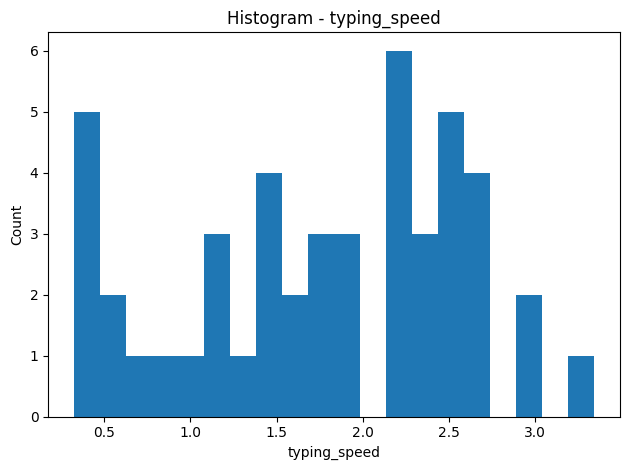

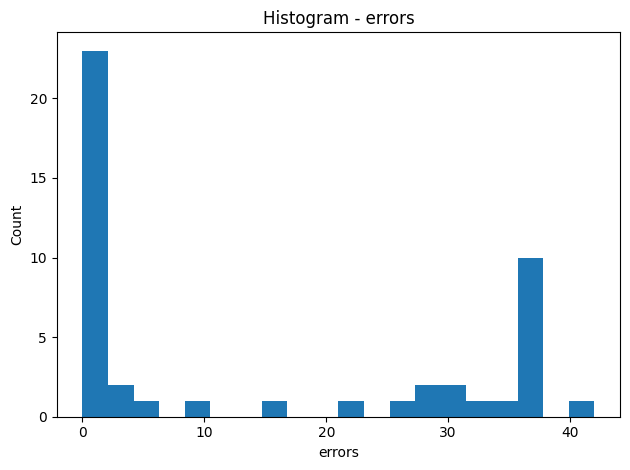

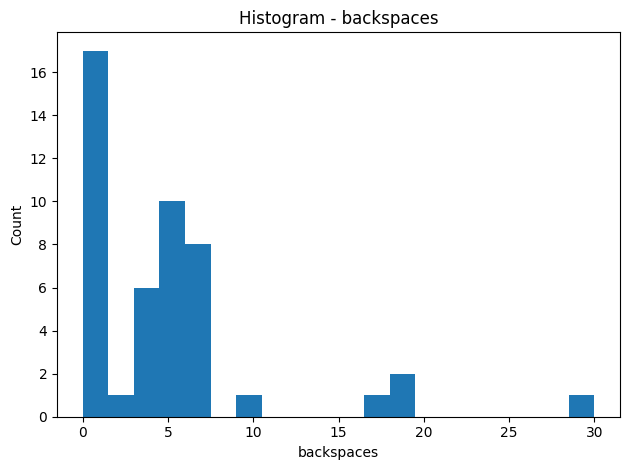

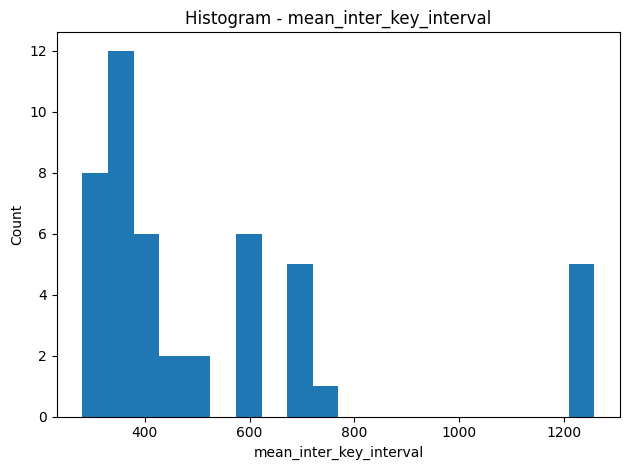

In [ ]:
for col in ["typing_speed","errors","backspaces","mean_inter_key_interval"]:
    if col in df.columns:
        plt.figure()
        plt.hist(df[col].dropna(), bins=20)
        plt.title(f"Histogram - {col}")df[""]
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


In [15]:
agg_df = df.groupby("label").agg({
    "errors": ["min", "max", "mean"],
    "typing_speed": ["min", "max", "mean"],
    "backspaces" : ["min", "max", "mean"],
    "mean_inter_key_interval" : ["min", "max", "mean"]
})


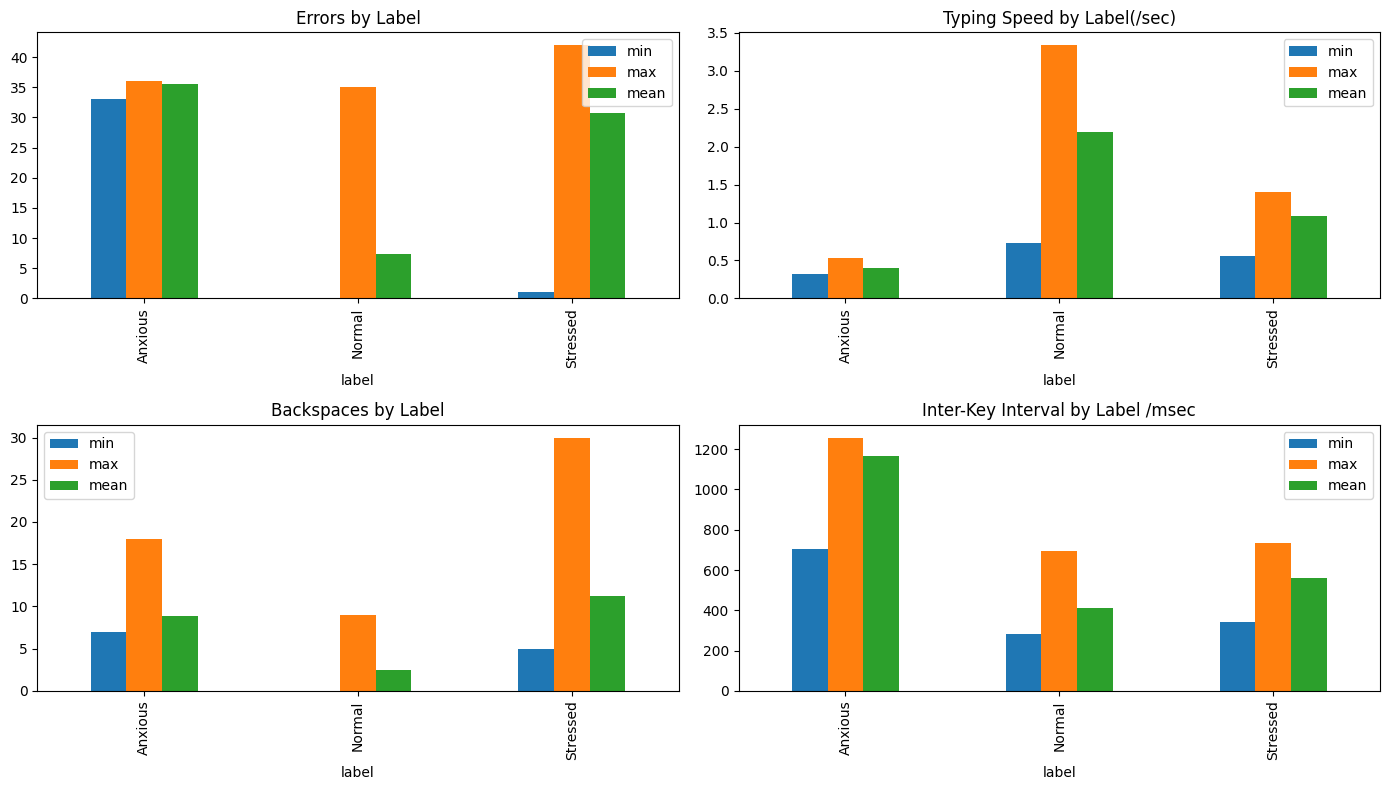

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14,8))  # 2x2 grid

agg_df["errors"].plot(kind="bar", ax=axs[0,0], title="Errors by Label")
agg_df["typing_speed"].plot(kind="bar", ax=axs[0,1], title="Typing Speed by Label(/sec)")
agg_df["backspaces"].plot(kind="bar", ax=axs[1,0], title="Backspaces by Label")
agg_df["mean_inter_key_interval"].plot(kind="bar", ax=axs[1,1], title="Inter-Key Interval by Label /msec")

plt.tight_layout()
plt.show()

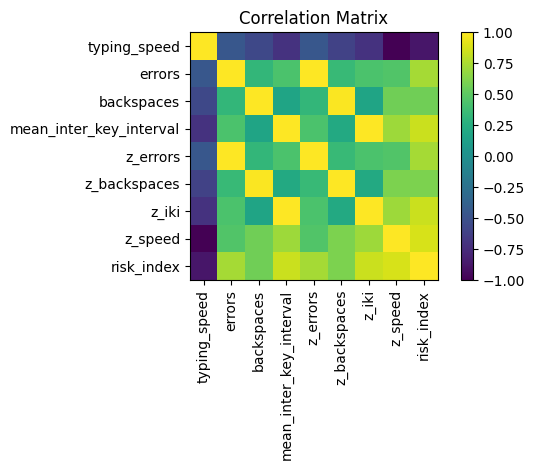

In [ ]:
corr = df[numeric_cols].corr()
plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


Train/Test split

In [ ]:
features = ["typing_speed","errors","backspaces","mean_inter_key_interval"]

In [ ]:
X = df[features].copy()
y = df["label"].copy()

In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [ ]:
classes, counts = np.unique(y_enc, return_counts=True)
min_class = counts.min()

In [ ]:
stratify = y_enc if min_class >= 2 else None
test_size = 0.3 if len(df) >= 40 else 0.4

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=test_size, random_state=42, stratify=stratify
)

 Pipeline: Scaling + RF

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),                # RF doesn't need scaling, but included as requested
    ("rf", RandomForestClassifier(random_state=42))
])




In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [ ]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9333
              precision    recall  f1-score   support

     Anxious       1.00      1.00      1.00         2
      Normal       1.00      0.90      0.95        10
    Stressed       0.75      1.00      0.86         3

    accuracy                           0.93        15
   macro avg       0.92      0.97      0.93        15
weighted avg       0.95      0.93      0.94        15



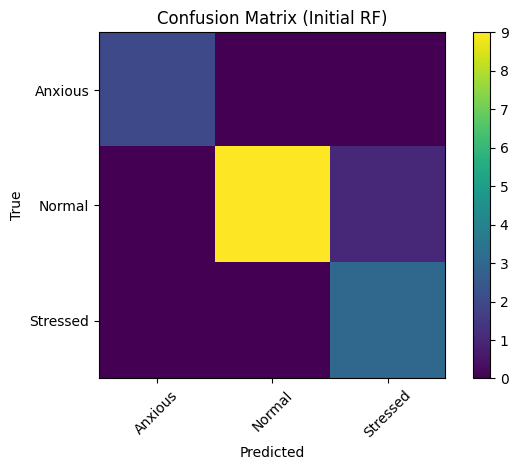

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Initial RF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
plt.tight_layout()
plt.show()

Hyperparameter Tuning (GridSearchCV)

In [ ]:
cv = StratifiedKFold(n_splits=min(5, min_class), shuffle=True, random_state=42)

In [ ]:
param_grid = {
    "rf__n_estimators": [100, 250, 500],
    "rf__max_depth": [None, 5, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__bootstrap": [True, False],
}

In [ ]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

In [ ]:
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
print("Best params:", grid.best_params_)
print("Best CV accuracy:", round(grid.best_score_, 4))

Best params: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 250}
Best CV accuracy: 0.9095


In [ ]:
y_pred_best = best_model.predict(X_test)

In [ ]:
print("Accuracy:", round(accuracy_score(y_test, y_pred_best), 4))
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

Accuracy: 0.9333
              precision    recall  f1-score   support

     Anxious       1.00      1.00      1.00         2
      Normal       1.00      0.90      0.95        10
    Stressed       0.75      1.00      0.86         3

    accuracy                           0.93        15
   macro avg       0.92      0.97      0.93        15
weighted avg       0.95      0.93      0.94        15



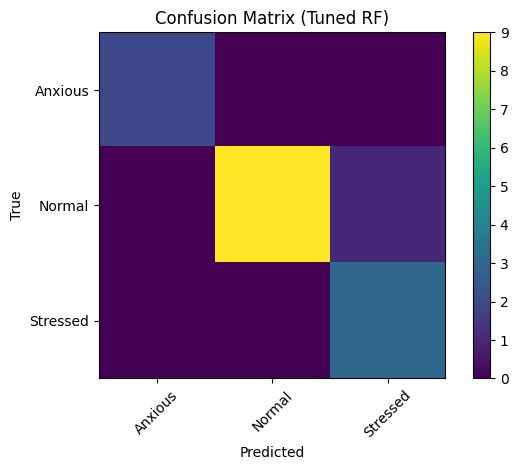

In [ ]:
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure()
plt.imshow(cm_best, interpolation='nearest')
plt.title("Confusion Matrix (Tuned RF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
plt.tight_layout()
plt.show()


Feature Importances

In [ ]:
rf_stage = best_model.named_steps["rf"]
fi = pd.DataFrame({
    "feature": features,
    "importance": rf_stage.feature_importances_
}).sort_values("importance", ascending=False)


In [ ]:
print(fi)

                   feature  importance
0             typing_speed    0.515608
3  mean_inter_key_interval    0.173674
1                   errors    0.167009
2               backspaces    0.143709


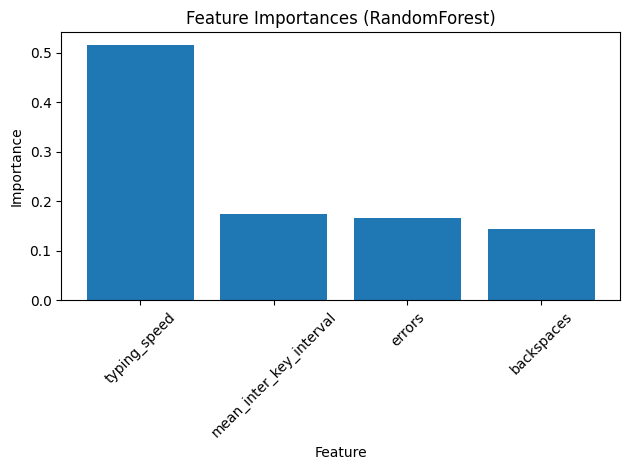

In [ ]:
plt.figure()
plt.bar(fi["feature"], fi["importance"])
plt.title("Feature Importances (RandomForest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PCA Analysis

In [ ]:
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

In [ ]:
pca_full = PCA().fit(X_scaled)
explained = pca_full.explained_variance_ratio_

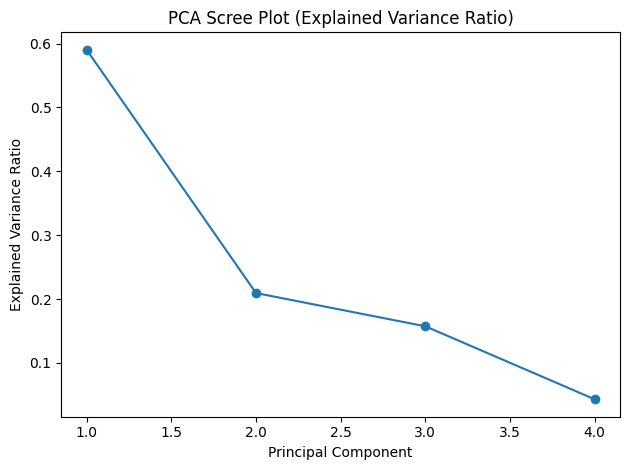

In [ ]:
plt.figure()
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("PCA Scree Plot (Explained Variance Ratio)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

2D PCA scatter

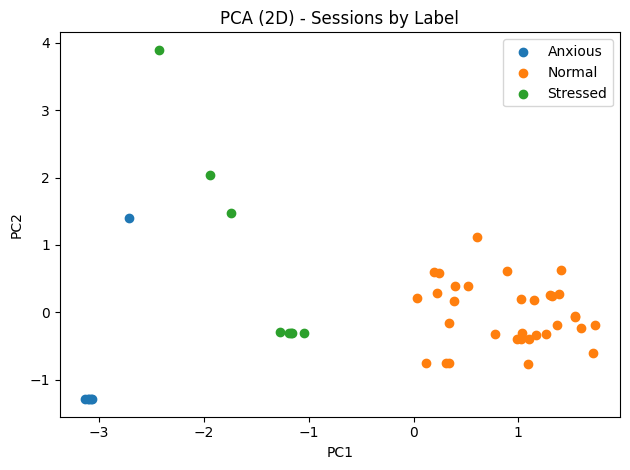

In [ ]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure()
for cls_idx, cls_name in enumerate(le.classes_):
    mask = (y_enc == cls_idx)
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1], label=cls_name)
plt.title("PCA (2D) - Sessions by Label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


 Decision boundary in PCA space

In [ ]:
X_train_scaled = scaler_full.fit_transform(X_train)
pca2_boundary = PCA(n_components=2).fit(X_train_scaled)
X_train_pca = pca2_boundary.transform(X_train_scaled)
X_test_scaled = scaler_full.transform(X_test)
X_test_pca = pca2_boundary.transform(X_test_scaled)

In [ ]:
rf_2d = RandomForestClassifier(random_state=42, n_estimators=300)
rf_2d.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


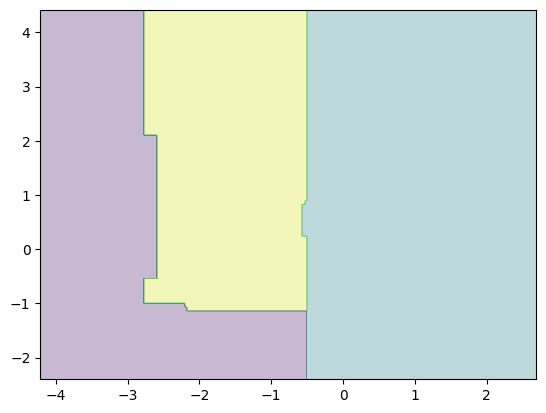

In [ ]:

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3)

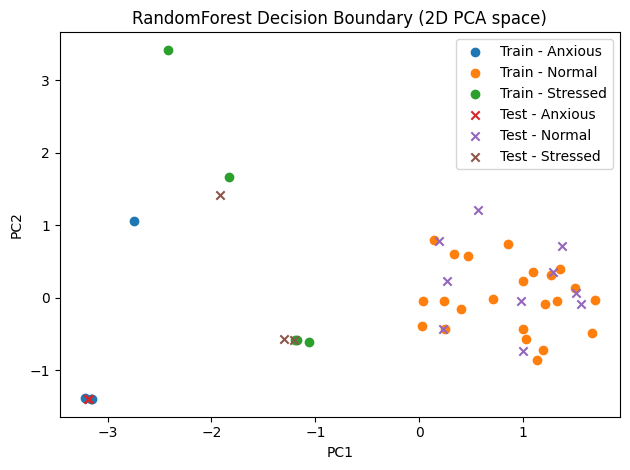

In [ ]:

for cls_idx, cls_name in enumerate(le.classes_):
    m_tr = (y_train == cls_idx)
    plt.scatter(X_train_pca[m_tr, 0], X_train_pca[m_tr, 1], label=f"Train - {cls_name}", marker='o')
# test points
for cls_idx, cls_name in enumerate(le.classes_):
    m_te = (y_test == cls_idx)
    plt.scatter(X_test_pca[m_te, 0], X_test_pca[m_te, 1], label=f"Test - {cls_name}", marker='x')
plt.title("RandomForest Decision Boundary (2D PCA space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()